In [ ]:
# =========================
# HU Clipping – Auditoría y Visualización Interactiva
# Aplica clipping de Hounsfield Units [-1024, 600] a un volumen aleatorio del ATM'22.
# Proporciona un log de auditoría completo y una visualización interactiva 3-en-1.
# =========================

import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# === 1. Configuración ===
# Rutas relativas: el notebook y TrainBatch1 están en el mismo directorio
DATA_PATHS = {
    "images_batch1": r"./TrainBatch1/imagesTr",
    "labels_batch1": r"./TrainBatch1/labelsTr",
    # "images_batch2": r"./TrainBatch2/imagesTr",  # Comentado: no está disponible
    # "labels_batch2": r"./TrainBatch2/labelsTr"   # Comentado: no está disponible
}

HU_MIN, HU_MAX = -1024, 600

# === 2. Selección aleatoria de un caso ===
# Solo se usa batch1, ya que batch2 no está disponible
batch_key = "batch1"  # Selecciona directamente batch1
images_dir = DATA_PATHS[f"images_{batch_key}"]
labels_dir = DATA_PATHS[f"labels_{batch_key}"]

# Lista y selecciona una imagen aleatoria
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".nii.gz")])
if not image_files:
    raise FileNotFoundError(f"No se encontraron imágenes en {images_dir}")

selected_image = random.choice(image_files)
case_id = selected_image.replace("_0000.nii.gz", "")

# Encuentra el label correspondiente
label_files = [f for f in os.listdir(labels_dir) if f.startswith(case_id) and f.endswith(".nii.gz")]
if not label_files:
    raise FileNotFoundError(f"No se encontró label para el caso '{case_id}' en {labels_dir}")
selected_label = label_files[0]

img_path = os.path.join(images_dir, selected_image)
lbl_path = os.path.join(labels_dir, selected_label)

# === 3. Carga y procesamiento ===
# Carga la imagen y el label
img_nii = nib.load(img_path)
vol_orig = img_nii.get_fdata(dtype=np.float32)
affine, header = img_nii.affine, img_nii.header

lbl_nii = nib.load(lbl_path)
vol_label = lbl_nii.get_fdata().astype(np.uint8)

# Aplica HU Clipping
vol_clipped = np.clip(vol_orig, HU_MIN, HU_MAX)

# === 4. Generación del Log de Auditoría ===
audit_log = {
    "Caso Analizado": case_id,
    "Ruta Imagen": img_path,
    "Ruta Label": lbl_path,
    "Dimensión del Volumen": vol_orig.shape,
    "Espaciado (mm)": tuple(round(s, 3) for s in header.get_zooms()),
    "HU Mín (Original)": float(vol_orig.min()),
    "HU Máx (Original)": float(vol_orig.max()),
    "HU Mín (Clipped)": float(vol_clipped.min()),
    "HU Máx (Clipped)": float(vol_clipped.max()),
    "Rango de Clipping Aplicado": f"[{HU_MIN}, {HU_MAX}] HU"
}

print("=" * 50)
print("       📊 LOG DE AUDITORÍA: HU CLIPPING")
print("=" * 50)
for key, value in audit_log.items():
    print(f"{key:<25}: {value}")
print("=" * 50)

# === 5. Visualización Interactiva ===
def visualize_axial_slice(slice_idx):
    """
    Muestra un corte axial con la imagen original, la imagen procesada y la máscara de label.
    """
    # Extrae el corte axial (Y) y rota para una vista estándar
    orig_slice = np.rot90(vol_orig[:, slice_idx, :], k=1)
    clipped_slice = np.rot90(vol_clipped[:, slice_idx, :], k=1)
    label_slice = np.rot90(vol_label[:, slice_idx, :], k=1)

    # Crea la figura
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Caso: {case_id} | Corte Axial Y={slice_idx}", fontsize=14, weight='bold')

    # Panel 1: Imagen Original
    axes[0].imshow(orig_slice, cmap="gray", vmin=-1024, vmax=600)
    axes[0].set_title("TC Original", fontsize=12)
    axes[0].axis("off")

    # Panel 2: Imagen con HU Clipping
    axes[1].imshow(clipped_slice, cmap="gray", vmin=-1024, vmax=600)
    axes[1].set_title("TC con HU Clipping", fontsize=12)
    axes[1].axis("off")

    # Panel 3: Label Manual (Ground Truth)
    axes[2].imshow(label_slice, cmap="nipy_spectral", vmin=0, vmax=vol_label.max())
    axes[2].set_title("Segmentación Manual (Label)", fontsize=12)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Determina un corte central por defecto
default_slice = vol_orig.shape[1] // 2

# Lanza el widget interactivo
interact(
    visualize_axial_slice,
    slice_idx=IntSlider(
        value=default_slice,
        min=0,
        max=vol_orig.shape[1] - 1,
        step=1,
        description="Corte Y:",
        continuous_update=False,
        style={'description_width': 'initial'}
    )
);

       📊 LOG DE AUDITORÍA: HU CLIPPING
Caso Analizado           : ATM_055
Ruta Imagen              : ./TrainBatch1/imagesTr\ATM_055_0000.nii.gz
Ruta Label               : ./TrainBatch1/labelsTr\ATM_055_0000.nii.gz
Dimensión del Volumen    : (512, 512, 779)
Espaciado (mm)           : (np.float32(0.82), np.float32(0.82), np.float32(0.5))
HU Mín (Original)        : -1024.0
HU Máx (Original)        : 3071.0
HU Mín (Clipped)         : -1024.0
HU Máx (Clipped)         : 600.0
Rango de Clipping Aplicado: [-1024, 600] HU


interactive(children=(IntSlider(value=256, continuous_update=False, description='Corte Y:', max=511, style=Sli…

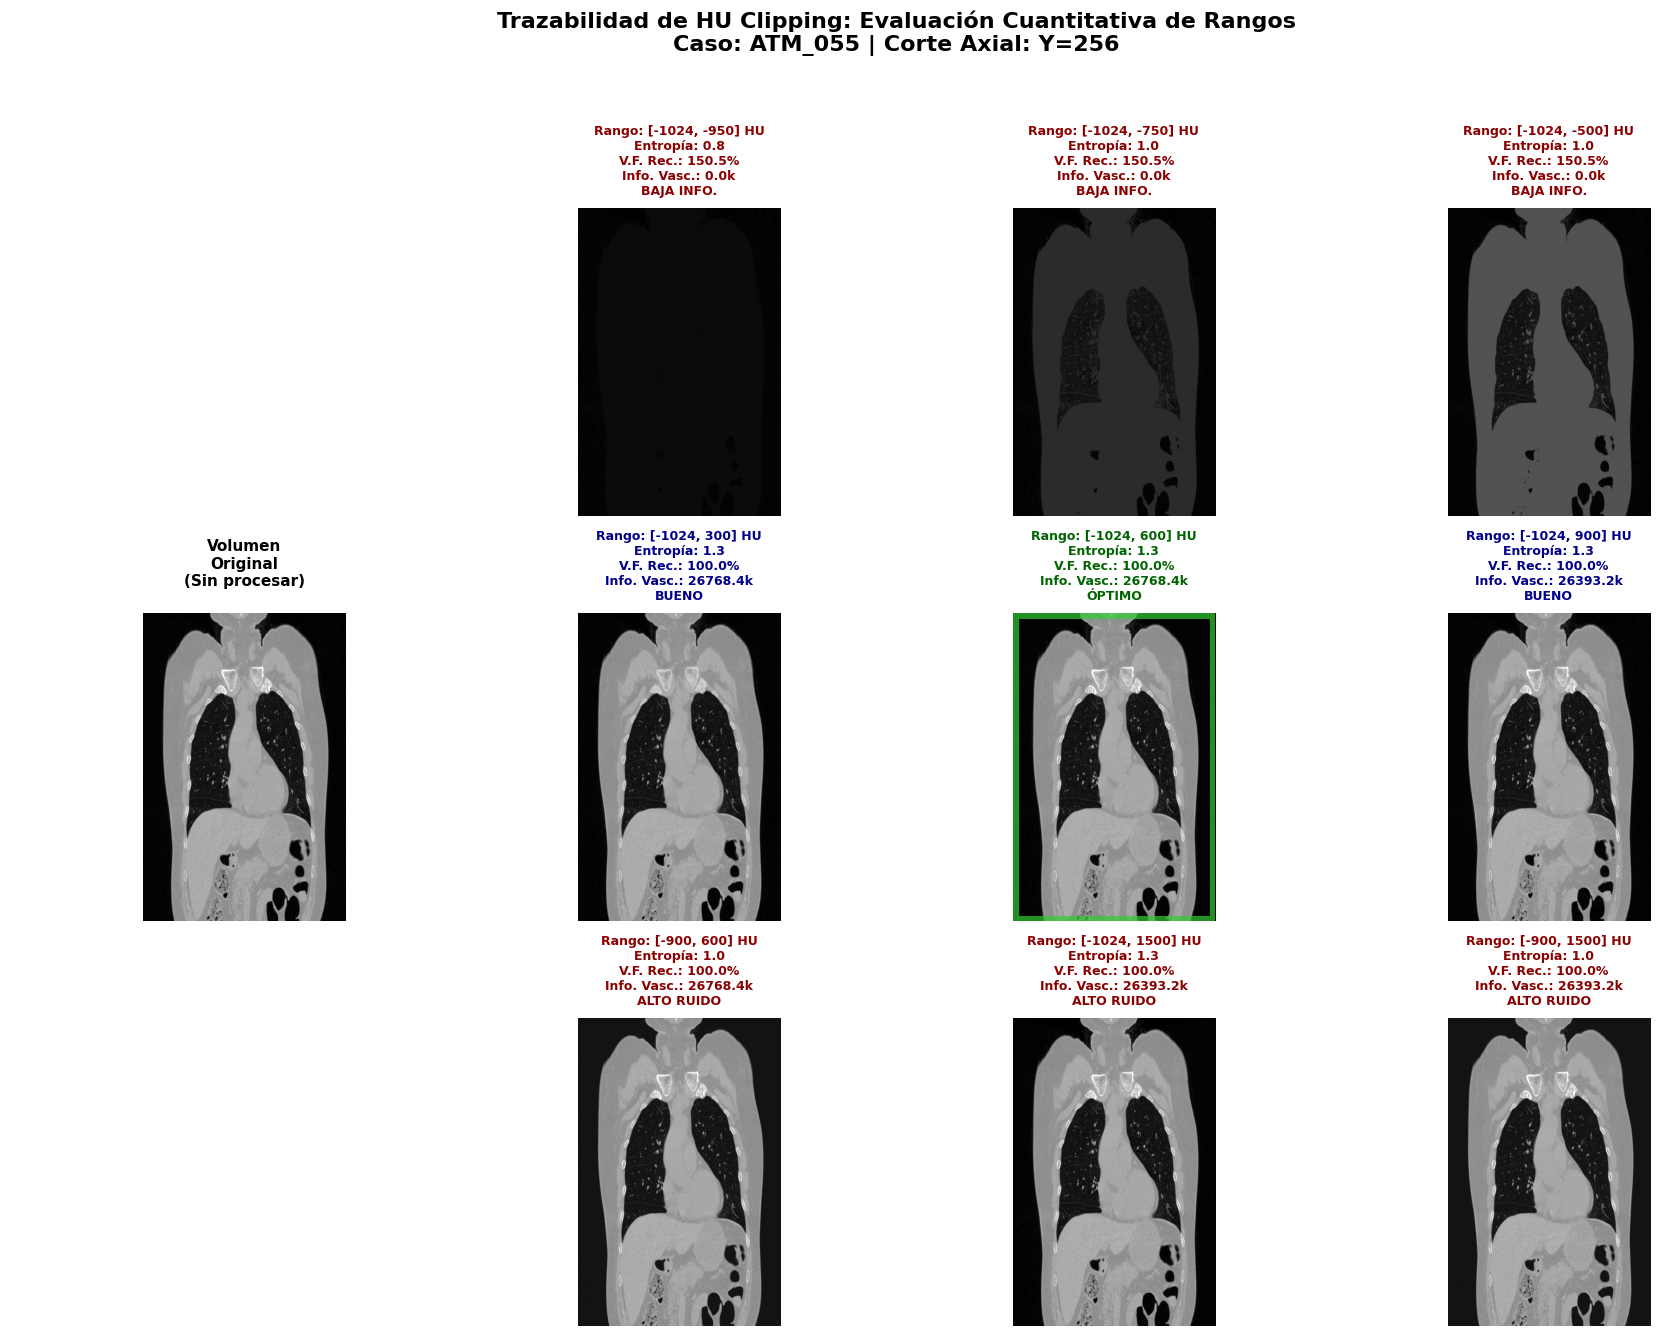


Rango Óptimo [-1024, 600] HU:
- Entropía de Shannon: 1.35 bits
- Volumen Funcional Recuperado: 100.0%
- Información Vascular Preservada: 26,768,410 vóxeles


In [ ]:
# =========================
# Trazabilidad de HU Clipping – Mosaico Comparativo con Métricas Cuantitativas
# Visualización del impacto de diferentes rangos de HU Clipping, enriquecida con métricas
# de Entropía, Volumen Funcional y Preservación Vascular para justificar la selección del rango óptimo.
# =========================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 1. Seleccionar un corte central representativo ===
slice_idx = vol_orig.shape[1] // 2
orig_slice = np.rot90(vol_orig[:, slice_idx, :], k=1)

# === 2. Función para calcular métricas cuantitativas ===
def calculate_clipping_metrics(clipped_vol, orig_vol):
    """
    Calcula métricas clave para evaluar la calidad de un volumen con HU Clipping.
    """
    # 1. Entropía de Shannon (medida de información/complejidad)
    hist, _ = np.histogram(clipped_vol, bins=256, range=(-1024, 600), density=True)
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist + 1e-10)) # +1e-10 para evitar log(0)
    
    # 2. Volumen Funcional Recuperado (Vóxeles en el rango de parénquima [-1024, -500])
    vf_clipped = np.sum((clipped_vol >= -1024) & (clipped_vol <= -500))
    vf_orig = np.sum((orig_vol >= -1024) & (orig_vol <= -500))
    vf_recovery = (vf_clipped / vf_orig) * 100 if vf_orig > 0 else 0.0
    
    # 3. Información Vascular Preservada (Vóxeles en [0, 600])
    vascular_info = np.sum((clipped_vol >= 0) & (clipped_vol <= 600))
    
    return entropy, vf_recovery, vascular_info

# === 3. Definir rangos de prueba y calcular métricas ===
test_ranges = [
    (-1024, -950), (-1024, -750), (-1024, -500),
    (-1024, 300),  (-1024, 600),  (-1024, 900),
    (-900, 600),   (-1024, 1500), (-900, 1500)
]

# Pre-calcular todas las métricas
all_metrics = []
for h_min, h_max in test_ranges:
    clipped_temp = np.clip(vol_orig, h_min, h_max)
    metrics = calculate_clipping_metrics(clipped_temp, vol_orig)
    all_metrics.append(metrics)

# Extraer listas para normalización visual (opcional, para colores)
entropies = [m[0] for m in all_metrics]
vf_recoveries = [m[1] for m in all_metrics]
vascular_infos = [m[2] for m in all_metrics]

# === 4. Crear el mosaico de 3x4 con métricas integradas ===
fig, axes = plt.subplots(3, 4, figsize=(18, 14))
fig.suptitle(
    f'Trazabilidad de HU Clipping: Evaluación Cuantitativa de Rangos\n'
    f'Caso: {case_id} | Corte Axial: Y={slice_idx}',
    fontsize=16, weight='bold', y=0.98
)

# --- Estilo global ---
plt.rcParams.update({'font.size': 9})
for ax in axes.flat:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# --- Columna 1: Volumen Original ---
axes[0, 0].axis('off')
axes[2, 0].axis('off')
ax_orig = axes[1, 0]
ax_orig.imshow(orig_slice, cmap='gray', vmin=-1024, vmax=600)
ax_orig.set_title('Volumen\nOriginal\n(Sin procesar)', fontsize=11, weight='bold', pad=20)
ax_orig.axis('off')

# --- Columnas 2-4: Escenarios de prueba con métricas ---
for i, (h_min, h_max) in enumerate(test_ranges):
    row = i // 3
    col = (i % 3) + 1
    ax = axes[row, col]
    
    # Aplicar clipping y obtener la vista
    clipped_test = np.clip(vol_orig, h_min, h_max)
    clipped_slice = np.rot90(clipped_test[:, slice_idx, :], k=1)
    ax.imshow(clipped_slice, cmap='gray', vmin=-1024, vmax=600)
    ax.axis('off')
    
    # Obtener métricas pre-calculadas
    entropy, vf_recovery, vascular_info = all_metrics[i]
    
    # Crear el texto del título con métricas
    title_lines = [
        f'Rango: [{h_min}, {h_max}] HU',
        f'Entropía: {entropy:.1f}',
        f'V.F. Rec.: {vf_recovery:.1f}%',
        f'Info. Vasc.: {vascular_info/1e3:.1f}k'
    ]
    
    # Determinar el diagnóstico y el color del título
    diagnosis, title_color = "", "black"
    if row == 0: # Fila 1: Pérdida de información
        diagnosis = "BAJA INFO."
        title_color = "darkred"
    elif row == 2: # Fila 3: Ruido/Artefactos
        diagnosis = "ALTO RUIDO"
        title_color = "darkred"
    else: # Fila 2: Rangos óptimos
        if (h_min, h_max) == (-1024, 600):
            diagnosis = "ÓPTIMO"
            title_color = "darkgreen"
        else:
            diagnosis = "BUENO"
            title_color = "darkblue"
    
    title_lines.append(diagnosis)
    full_title = "\n".join(title_lines)
    ax.set_title(full_title, fontsize=9, pad=10, color=title_color, weight='bold')
    
    # Destacar el rango óptimo
    if (h_min, h_max) == (-1024, 600):
        rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                         color='limegreen', linewidth=8, fill=False, alpha=0.7)
        ax.add_patch(rect)

# Ajustar layout y mostrar
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# === 5. Resumen de la Métrica Óptima (Opcional, para la celda siguiente) ===
optimal_idx = 4 # Índice de (-1024, 600) en la lista
opt_entropy, opt_vf, opt_vasc = all_metrics[optimal_idx]
print(f"\nRango Óptimo [-1024, 600] HU:")
print(f"- Entropía de Shannon: {opt_entropy:.2f} bits")
print(f"- Volumen Funcional Recuperado: {opt_vf:.1f}%")
print(f"- Información Vascular Preservada: {opt_vasc:,} vóxeles")

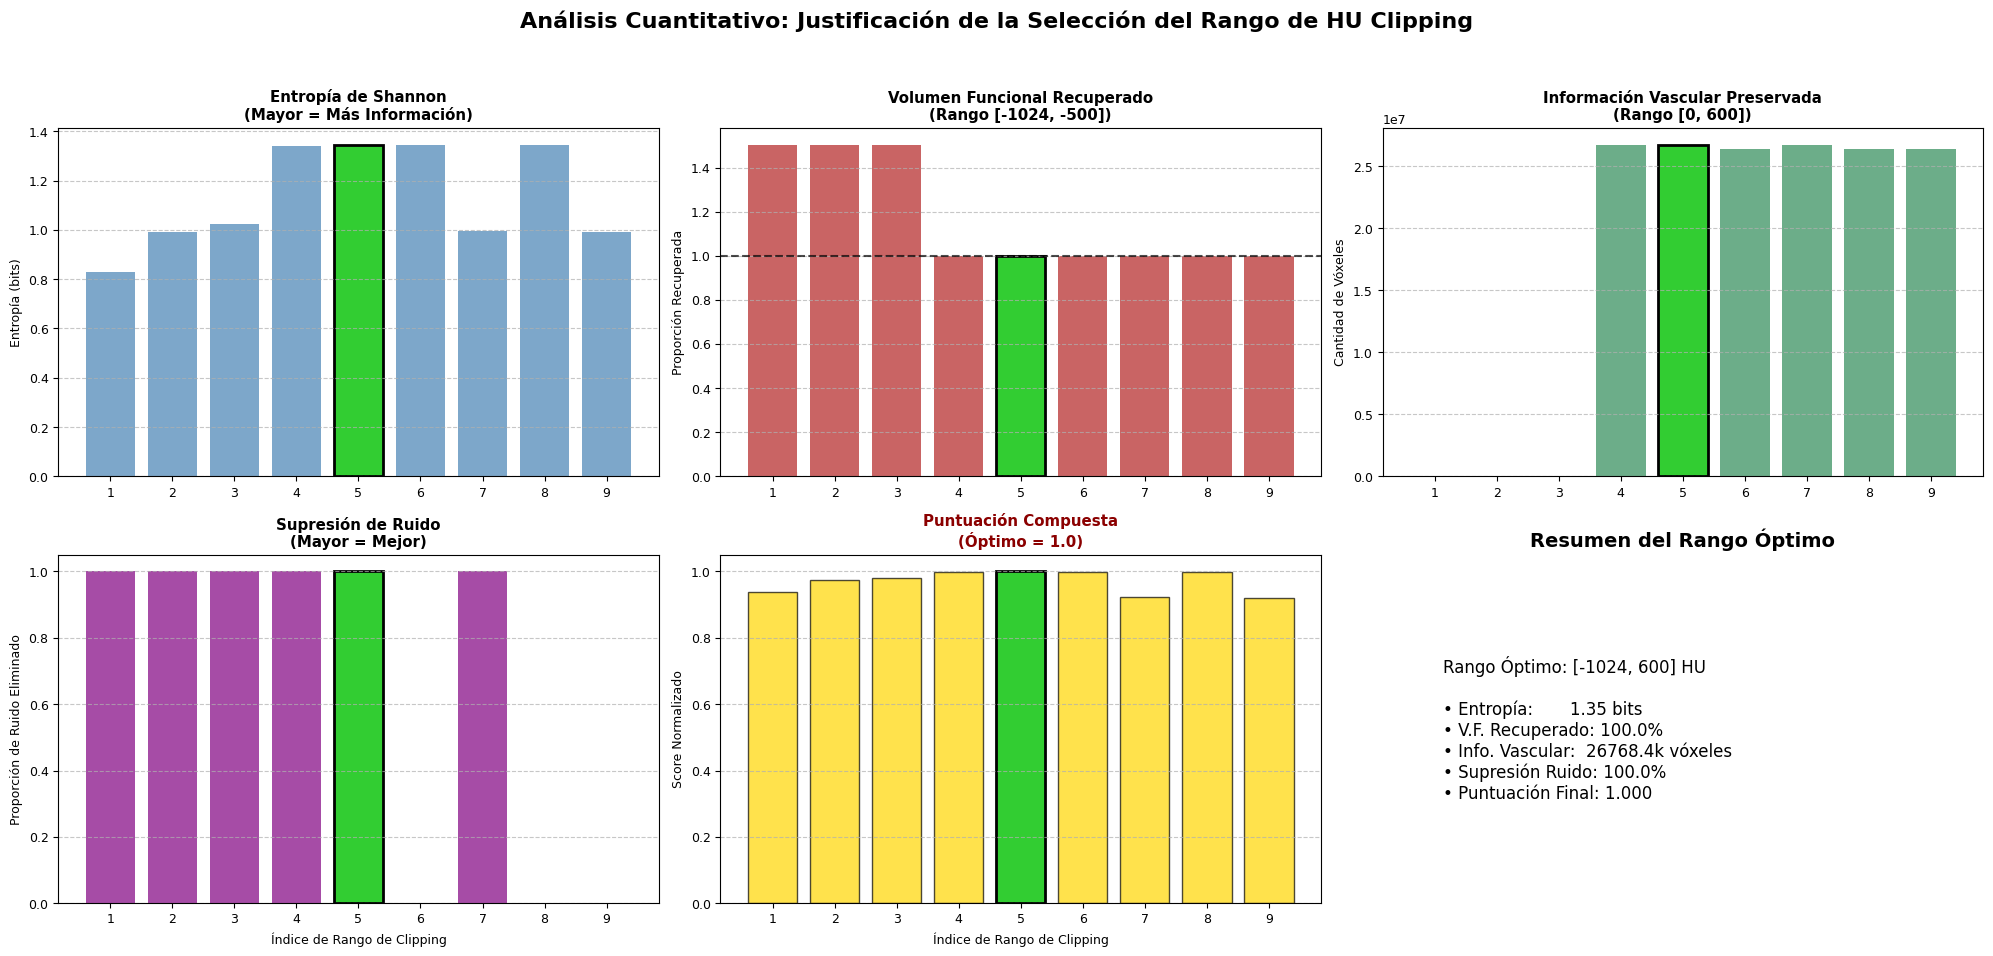

In [ ]:
# =========================
# Justificación Cuantitativa del Rango de HU Clipping
# Análisis comparativo de métricas que respaldan la elección del rango [-1024, 600].
# Incluye métricas de información, preservación funcional y robustez al ruido.
# =========================


import numpy as np
import matplotlib.pyplot as plt

# === Función corregida: solo calcula métricas primarias ===
def calculate_primary_metrics(h_min, h_max):
    """
    Calcula las métricas fundamentales para evaluar la calidad del HU Clipping.
    """
    clipped = np.clip(vol_orig, h_min, h_max)
    
    # 1. Entropía de Shannon (Información/Complejidad)
    hist, _ = np.histogram(clipped, bins=256, range=(-1024, 600), density=True)
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    
    # 2. Volumen Funcional Recuperado (Parénquima: [-1024, -500])
    vf_clipped = np.sum((clipped >= -1024) & (clipped <= -500))
    vf_orig = np.sum((vol_orig >= -1024) & (vol_orig <= -500))
    vf_recovery = vf_clipped / vf_orig if vf_orig > 0 else 0.0
    
    # 3. Información Vascular Preservada ([0, 600])
    vascular_info = np.sum((clipped >= 0) & (clipped <= 600))
    
    # 4. Supresión de Ruido (Vóxeles fuera del rango fisiológico [-1024, 600])
    noise_orig = np.sum(vol_orig < -1024) + np.sum(vol_orig > 600)
    noise_clipped = np.sum(clipped < -1024) + np.sum(clipped > 600)
    noise_suppression = (noise_orig - noise_clipped) / noise_orig if noise_orig > 0 else 1.0
    
    return entropy, vf_recovery, vascular_info, noise_suppression

# === Preparar los datos y calcular métricas ===
# Definir los rangos de prueba (deben coincidir con la celda del mosaico)
test_ranges = [
    (-1024, -950), (-1024, -750), (-1024, -500),
    (-1024, 300),  (-1024, 600),  (-1024, 900),
    (-900, 600),   (-1024, 1500), (-900, 1500)
]

# Calcular métricas para todos los rangos
all_metrics = []
for h_min, h_max in test_ranges:
    metrics = calculate_primary_metrics(h_min, h_max)
    all_metrics.append(metrics)

# Desempaquetar las métricas
entropies = [m[0] for m in all_metrics]
vf_recoveries = [m[1] for m in all_metrics]
vascular_infos = [m[2] for m in all_metrics]
noise_suppressions = [m[3] for m in all_metrics]

# === Calcular la Puntuación Compuesta (fuera de la función) ===
max_entropy = max(entropies)
max_vascular = max(vascular_infos)

composite_scores = []
for i in range(len(all_metrics)):
    entropy, vf_recovery, vascular_info, _ = all_metrics[i]
    score = (
        0.3 * (entropy / max_entropy) +
        0.5 * vf_recovery +
        0.2 * (vascular_info / max_vascular)
    )
    composite_scores.append(score)

# === Crear la figura de análisis comparativo ===
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Análisis Cuantitativo: Justificación de la Selección del Rango de HU Clipping', 
             fontsize=16, weight='bold', y=0.98)

# Lista de todas las barras para destacar el rango óptimo
all_bars = []

# --- Fila 1: Métricas Primarias ---
# Entropía de Shannon
bars1 = axs[0, 0].bar(range(1, 10), entropies, color='steelblue', alpha=0.7)
all_bars.append(bars1)
axs[0, 0].set_title('Entropía de Shannon\n(Mayor = Más Información)', weight='bold')
axs[0, 0].set_ylabel('Entropía (bits)')
axs[0, 0].set_xticks(range(1, 10))
axs[0, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

# Volumen Funcional Recuperado
bars2 = axs[0, 1].bar(range(1, 10), vf_recoveries, color='firebrick', alpha=0.7)
all_bars.append(bars2)
axs[0, 1].set_title('Volumen Funcional Recuperado\n(Rango [-1024, -500])', weight='bold')
axs[0, 1].set_ylabel('Proporción Recuperada')
axs[0, 1].set_xticks(range(1, 10))
axs[0, 1].axhline(y=1.0, color='black', linestyle='--', alpha=0.7)
axs[0, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

# Información Vascular Preservada
bars3 = axs[0, 2].bar(range(1, 10), vascular_infos, color='seagreen', alpha=0.7)
all_bars.append(bars3)
axs[0, 2].set_title('Información Vascular Preservada\n(Rango [0, 600])', weight='bold')
axs[0, 2].set_ylabel('Cantidad de Vóxeles')
axs[0, 2].set_xticks(range(1, 10))
axs[0, 2].grid(True, axis='y', linestyle='--', alpha=0.7)

# --- Fila 2: Métricas de Robustez y Síntesis ---
# Supresión de Ruido
bars4 = axs[1, 0].bar(range(1, 10), noise_suppressions, color='purple', alpha=0.7)
all_bars.append(bars4)
axs[1, 0].set_title('Supresión de Ruido\n(Mayor = Mejor)', weight='bold')
axs[1, 0].set_ylabel('Proporción de Ruido Eliminado')
axs[1, 0].set_xlabel('Índice de Rango de Clipping')
axs[1, 0].set_xticks(range(1, 10))
axs[1, 0].grid(True, axis='y', linestyle='--', alpha=0.7)

# Puntuación Compuesta (La más importante)
bars5 = axs[1, 1].bar(range(1, 10), composite_scores, color='gold', alpha=0.7, edgecolor='black')
all_bars.append(bars5)
axs[1, 1].set_title('Puntuación Compuesta\n(Óptimo = 1.0)', weight='bold', color='darkred')
axs[1, 1].set_ylabel('Score Normalizado')
axs[1, 1].set_xlabel('Índice de Rango de Clipping')
axs[1, 1].set_xticks(range(1, 10))
axs[1, 1].grid(True, axis='y', linestyle='--', alpha=0.7)

# --- Panel de Resumen: Tabla del Rango Óptimo ---
optimal_idx = 4 # Índice del rango [-1024, 600]
opt_entropy, opt_vf, opt_vasc, opt_noise = all_metrics[optimal_idx]
opt_score = composite_scores[optimal_idx]

summary_text = (
    f"Rango Óptimo: [-1024, 600] HU\n\n"
    f"• Entropía:       {opt_entropy:.2f} bits\n"
    f"• V.F. Recuperado: {opt_vf*100:.1f}%\n"
    f"• Info. Vascular:  {opt_vasc/1e3:.1f}k vóxeles\n"
    f"• Supresión Ruido: {opt_noise*100:.1f}%\n"
    f"• Puntuación Final: {opt_score:.3f}"
)
axs[1, 2].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center', transform=axs[1, 2].transAxes)
axs[1, 2].set_title('Resumen del Rango Óptimo', weight='bold', fontsize=14)
axs[1, 2].axis('off')

# === Destacar el rango óptimo en todos los gráficos ===
OPTIMAL_BAR_INDEX = 4
OPTIMAL_COLOR = 'limegreen'
for bars in all_bars:
    bars[OPTIMAL_BAR_INDEX].set_color(OPTIMAL_COLOR)
    bars[OPTIMAL_BAR_INDEX].set_alpha(1.0)
    bars[OPTIMAL_BAR_INDEX].set_edgecolor('black')
    bars[OPTIMAL_BAR_INDEX].set_linewidth(2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()